# Data overview for Final Project

## Downloading the data from Statistikbank.dk

The private ownership of cars in Copenhagen has been counted since 2006. The dataset can be found at [Købanhavns Kommunes Statistikbank](https://kk.statistikbank.dk) under the _Privatbiler_ tab. There are multiple options for which data to extract, based on fuel type, district, family structure, vehicle type etc.. 

For this project, the dataset collected can be found folliwng these steps: 

1. Go to the website and follow these tabs:
- `Privatbiler` 
    - `Personbiler` 
        - `KKBIL1: Privatbiler efter distrikt og drivmiddel`

2. Select all rows in each dropdown, except the "_København i alt_" under _DISTRIKT_ and "_Drivmiddel i alt_" under _DRIVMIDDEL_. 
3. Click "_VIS TABEL_". 
4. Make sure to toggle off "_Inkl. koder i sep. kolonner_" and "_Inkl. fodnoter mv._".
5. Select "_Semikolonsepareret (*.csv)_" in the dropdown "_Åbn / gem som..._".
6. Rename the .csv to "KKBIL.csv"

### Disclaimer:

The dataset being activily maintained, so values may vary over time.

The cleaned data produced from this notebook has substituted NaN values in the NoOfVehicles columns with -1.

For further data analysis, these values most be handled.

## Preamble

In [65]:
import folium
from folium.plugins import HeatMap, HeatMapWithTime
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import os

In [66]:
# Set pandas display options to show all columns for .head command
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", None)        # Auto-detect the display width
pd.set_option("display.max_colwidth", None) # Show full content of each column

In [67]:
# Loading the data and files
data_path = os.path.abspath(os.path.join(os.pardir, "projectData"))

# Read shapefile from the provided geojson file
geojson_name = "bydel.geojson"
geojson_path = os.path.join(data_path, geojson_name)

# Open geojson data to load shape of police districts
with open(geojson_path) as response:
    geojson_data = json.load(response)

# Load csv data into pandas dataframe
cars_registered_name = "KKBIL.csv"
cars_registered_path = os.path.join(data_path, cars_registered_name)
df = pd.read_csv(cars_registered_path, encoding="ISO-8859-1")

In [68]:
# RAW downloaded data
df.head()

,Benzin,Bydel - Indre By,8675,9015,9016,8831,8758,8572,8489,8429,8549,8671,8921,9003,8991,9122,9276,9593,9250,8810,8493
0,Benzin,Bydel - Østerbro,12302,12666,12870,12782,12592,12354,12184,12022,12162,12337,12631,12901,13238,13344,13530,14098,14048,13470,12842
1,Benzin,Bydel - Nørrebro,8930,9197,9276,8869,8616,8382,8166,8061,8244,8589,8783,9112,9558,9677,9825,10488,10614,10157,9720
2,Benzin,Bydel - Vesterbro/Kongens Enghave,6634,7248,7499,7733,7753,7846,7636,7600,7868,8105,8381,8767,9200,9606,9949,10616,10987,10611,10045
3,Benzin,Bydel - Valby,8867,9094,9166,9114,9121,9102,9002,9020,9228,9472,9643,9888,10234,10541,10810,11477,11510,11237,10821
4,Benzin,Bydel - Vanløse,8146,8289,8262,8097,8033,8006,7945,7937,7952,8110,8296,8313,8451,8548,8625,8817,8843,8500,8291


# Vehicle ownership in Copenhagen between 2006 - 2024

## Restructure and clean the dataset

### Create new columns and transform the dataframe

In [69]:
# Manually assign the start and end year of the dataset, depending on time fetched from website
start_y = 2006
end_y = 2024

# Create new columns
new_cols = ["FuelType", "CityDistrict", *list(range(start_y, end_y+1, 1))]

# Shift table downwards, so that current header becomes first row, then assign the new custom header
df_ncols = (df.T.reset_index().T.reset_index(drop=True).set_axis(new_cols, axis=1))

In [70]:
# Melt the number of registered vehicles and years with the remaining columns
df_melted = df_ncols.melt(
    id_vars=[
        "FuelType", 
        "CityDistrict"
    ], 
    var_name="Year", 
    value_name="NoOfVehicles"
)

In [71]:
# Convert datatypes for each row
df_melted["FuelType"] = df_melted["FuelType"].astype(str)
df_melted["CityDistrict"] = df_melted["CityDistrict"].astype(str)
df_melted["Year"] = df_melted["Year"].astype("uint16")

# Replace NaN with -1 and then convert to int
df_melted["NoOfVehicles"] = pd.to_numeric(df_melted["NoOfVehicles"], errors='coerce')
df_melted["NoOfVehicles"] = df_melted["NoOfVehicles"].fillna(-1)
df_melted["NoOfVehicles"] = df_melted["NoOfVehicles"].astype(int)

In [72]:
# Sort the dataframe alphabetically and chronologically
df_melted = df_melted.sort_values(
    by=[
        "FuelType",
        "CityDistrict",
        "Year",
    ], 
    axis=0,
    ascending=True)

### Remove out-of-scope and summarized rows

In [73]:
# Remove noninformative rows for "other" and "non-desclosed" fuel types
df_melted = df_melted[df_melted["FuelType"]!="Øvrige og uoplyst"]

# Rmove districts outside of CPH
df_melted = df_melted[~df_melted["CityDistrict"].str.contains("Uden for inddeling", case=False, na=False)]

In [74]:
# Extract larger districts
df_bydel = df_melted[df_melted["CityDistrict"].str.contains("Bydel", case=False, na=False)]
df_lokaludvalg = df_melted[df_melted["CityDistrict"].str.contains("Lokaludvalg", case=False, na=False)]

# # Store separately
# bydel_name = "KKBIL_BYDEL.csv"
# bydel_path = os.path.join(data_path, bydel_name)
# df_bydel.to_csv(bydel_path, index=False)

# lokaludvalg_name = "KKBIL_LOKALUDVALG.csv"
# lokaludvalg_path = os.path.join(data_path, lokaludvalg_name)
# df_lokaludvalg.to_csv(lokaludvalg_path, index=False)

# Remove from main dataframe
df_melted = df_melted[~df_melted["CityDistrict"].str.contains("Bydel|Lokaludvalg", case=False, na=False)]

### Extract Lokaludvalg from sub-districts

In [75]:
df_clean = df_melted.copy()
df_clean.insert(1, "Lokaludvalg", "X")

In [76]:
# Extract list with all district names
lokaludvalg_unique = df_lokaludvalg["CityDistrict"].unique().tolist()
lokaludvalg_list = []
for r in lokaludvalg_unique:
    lokaludvalg_list.append(r.replace("Lokaludvalg - ", ""))

In [77]:
# Generate column values based on district
for district in lokaludvalg_list:
    mask = df_clean["CityDistrict"].str.contains(district, na=False)
    df_clean.loc[mask, "Lokaludvalg"] = district
    df_clean.loc[mask, "CityDistrict"] = df_clean.loc[mask, "CityDistrict"].str.replace(district, "", n=1).str.replace("-", "", n=1).str.strip()

### Join Lokaludvalg into Bydel

In [78]:
# Align with the names found in the geojson data
bydel_unique = df_bydel["CityDistrict"].unique().tolist()
bydel_list = []
for r in bydel_unique:
    bydel_list.append(r.replace("Bydel - ", "").replace("/", "-"))

In [79]:
df_clean.insert(1, "Bydel", "X")
df_clean["Bydel"] = df_clean["Lokaludvalg"]

In [80]:
# Examine differences between Lokaludvalg and Bydel
s1 = set(lokaludvalg_list)
s2 = set(bydel_list)
print(f"Uniquely in Lokaludvalg:\n{s1.difference(s2)}")
print(f"Uniquely in Bydel:\n{s2.difference(s1)}")

Uniquely in Lokaludvalg:
{'Vesterbro', 'Kgs. Enghave', 'Christianshavn'}
Uniquely in Bydel:
{'Vesterbro-Kongens Enghave'}


In [81]:
# Manually handle outliers
mask = df_clean["Bydel"].str.contains("Kgs. Enghave|Vesterbro", na=False)
df_clean.loc[mask, "Bydel"] = "Vesterbro-Kongens Enghave"

mask = df_clean["Bydel"].str.contains("Christianshavn", na=False)
df_clean.loc[mask, "Bydel"] = "Indre By"

In [82]:
# Rename and then display sample of cleaned data
df_clean = df_clean.rename(columns={
    "Bydel": "CityDistrict",	
    "Lokaludvalg": "LocalDistrict",
    "CityDistrict": "Neighbourhood",
})
df_clean.head()

,FuelType,CityDistrict,LocalDistrict,Neighbourhood,Year,NoOfVehicles
80,Benzin,Amager Vest,Amager Vest,Amagerbro Vest,2006,1030
540,Benzin,Amager Vest,Amager Vest,Amagerbro Vest,2007,1055
1000,Benzin,Amager Vest,Amager Vest,Amagerbro Vest,2008,1108
1460,Benzin,Amager Vest,Amager Vest,Amagerbro Vest,2009,1071
1920,Benzin,Amager Vest,Amager Vest,Amagerbro Vest,2010,1035


### Save the cleaned data into a new csv

In [83]:
# Store cleaned dataframe to new csv file
cleaned_name = "private_vehicle_ownership_copenhagen.csv"
cleaned_path = os.path.join(data_path, cleaned_name)
df_clean.to_csv(cleaned_path, index=False)


## Quick statistics over the cleaned dataset

In [84]:
print("Dataset: Car-ownership in CPH")
# Size of cleaned data
memory_mb = os.path.getsize(cleaned_path) / (1024) 
print(f"- Size of csv: {memory_mb:.2f} KB")

# Dimension of table
print("- No cols:", df_clean.shape[1])
print("- No rows:", df_clean.shape[0])

# Column names
print("\nColumn names:")
max_len = len(max(df_clean.columns, key=len))
for c in df_clean.columns:
    print(f"- {c:{" "}{"<"}{max_len}} : {type(df_clean[c].iloc[0])}")

Dataset: Car-ownership in CPH
- Size of csv: 274.82 KB
- No cols: 6
- No rows: 5092

Column names:
- FuelType      : <class 'str'>
- CityDistrict  : <class 'str'>
- LocalDistrict : <class 'str'>
- Neighbourhood : <class 'str'>
- Year          : <class 'numpy.uint16'>
- NoOfVehicles  : <class 'numpy.int64'>


## Simple visualisations

In [85]:
# Path for storing the plots
plots_path = os.path.abspath(os.path.join(os.pardir, os.path.join("plots", "Project")))

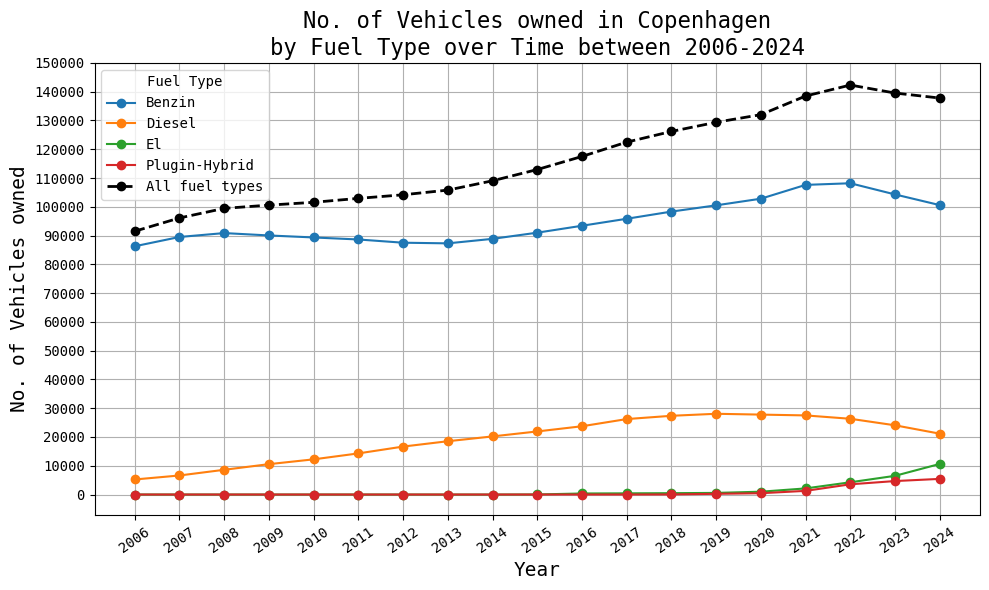

In [86]:
font_defined = "monospace"

# Group by year and fuel type, then summarize by noofvehicles, then fiannly pivot to correst format
df_grouped = df_clean.groupby(["Year", "FuelType"])["NoOfVehicles"].sum().reset_index()
df_pivot = df_grouped.pivot(index="Year", columns="FuelType", values="NoOfVehicles")

# Plot pivotted dataframe as lines
ax = df_pivot.plot(kind="line", marker='o', figsize=(10, 6))

# Compute the total no. of vehicles per year for all fuel types combined
df_total = df_pivot.sum(axis=1).reset_index()
df_total.columns = ["Year", "TotalVehicles"]
ax.plot(df_total["Year"], df_total["TotalVehicles"], color='black', marker='o', label='All fuel types', linestyle='--', linewidth=2)
    
# Force all years to show on the x-axis
ax.set_xticks(df_pivot.index)  # these are your actual year values
ax.set_xticklabels(df_pivot.index, rotation=35)  # rotate for readability

# Calculate range intervals for yticks
interval = 10_000
max_val = df_total.max().max()
top_val = int(math.ceil(max_val / interval)) * interval
ax.set_yticks(list(range(0, top_val+interval, interval)))

# Set title, labels, legeng and grid
plt.rcParams['font.family'] = font_defined
plt.title(f"No. of Vehicles owned in Copenhagen\nby Fuel Type over Time between {start_y}-{end_y}", fontsize=16)
plt.xlabel("Year", fontdict={'family':font_defined,'color':'black','size':14})
plt.ylabel("No. of Vehicles owned", fontdict={'family':font_defined,'color':'black','size':14})
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title="Fuel Type")
plt.grid(visible=True)

plt.tight_layout()
plt.savefig(os.path.join(plots_path, "Vehicle_ownership_CPH_2006_2024.pdf"))
plt.show()

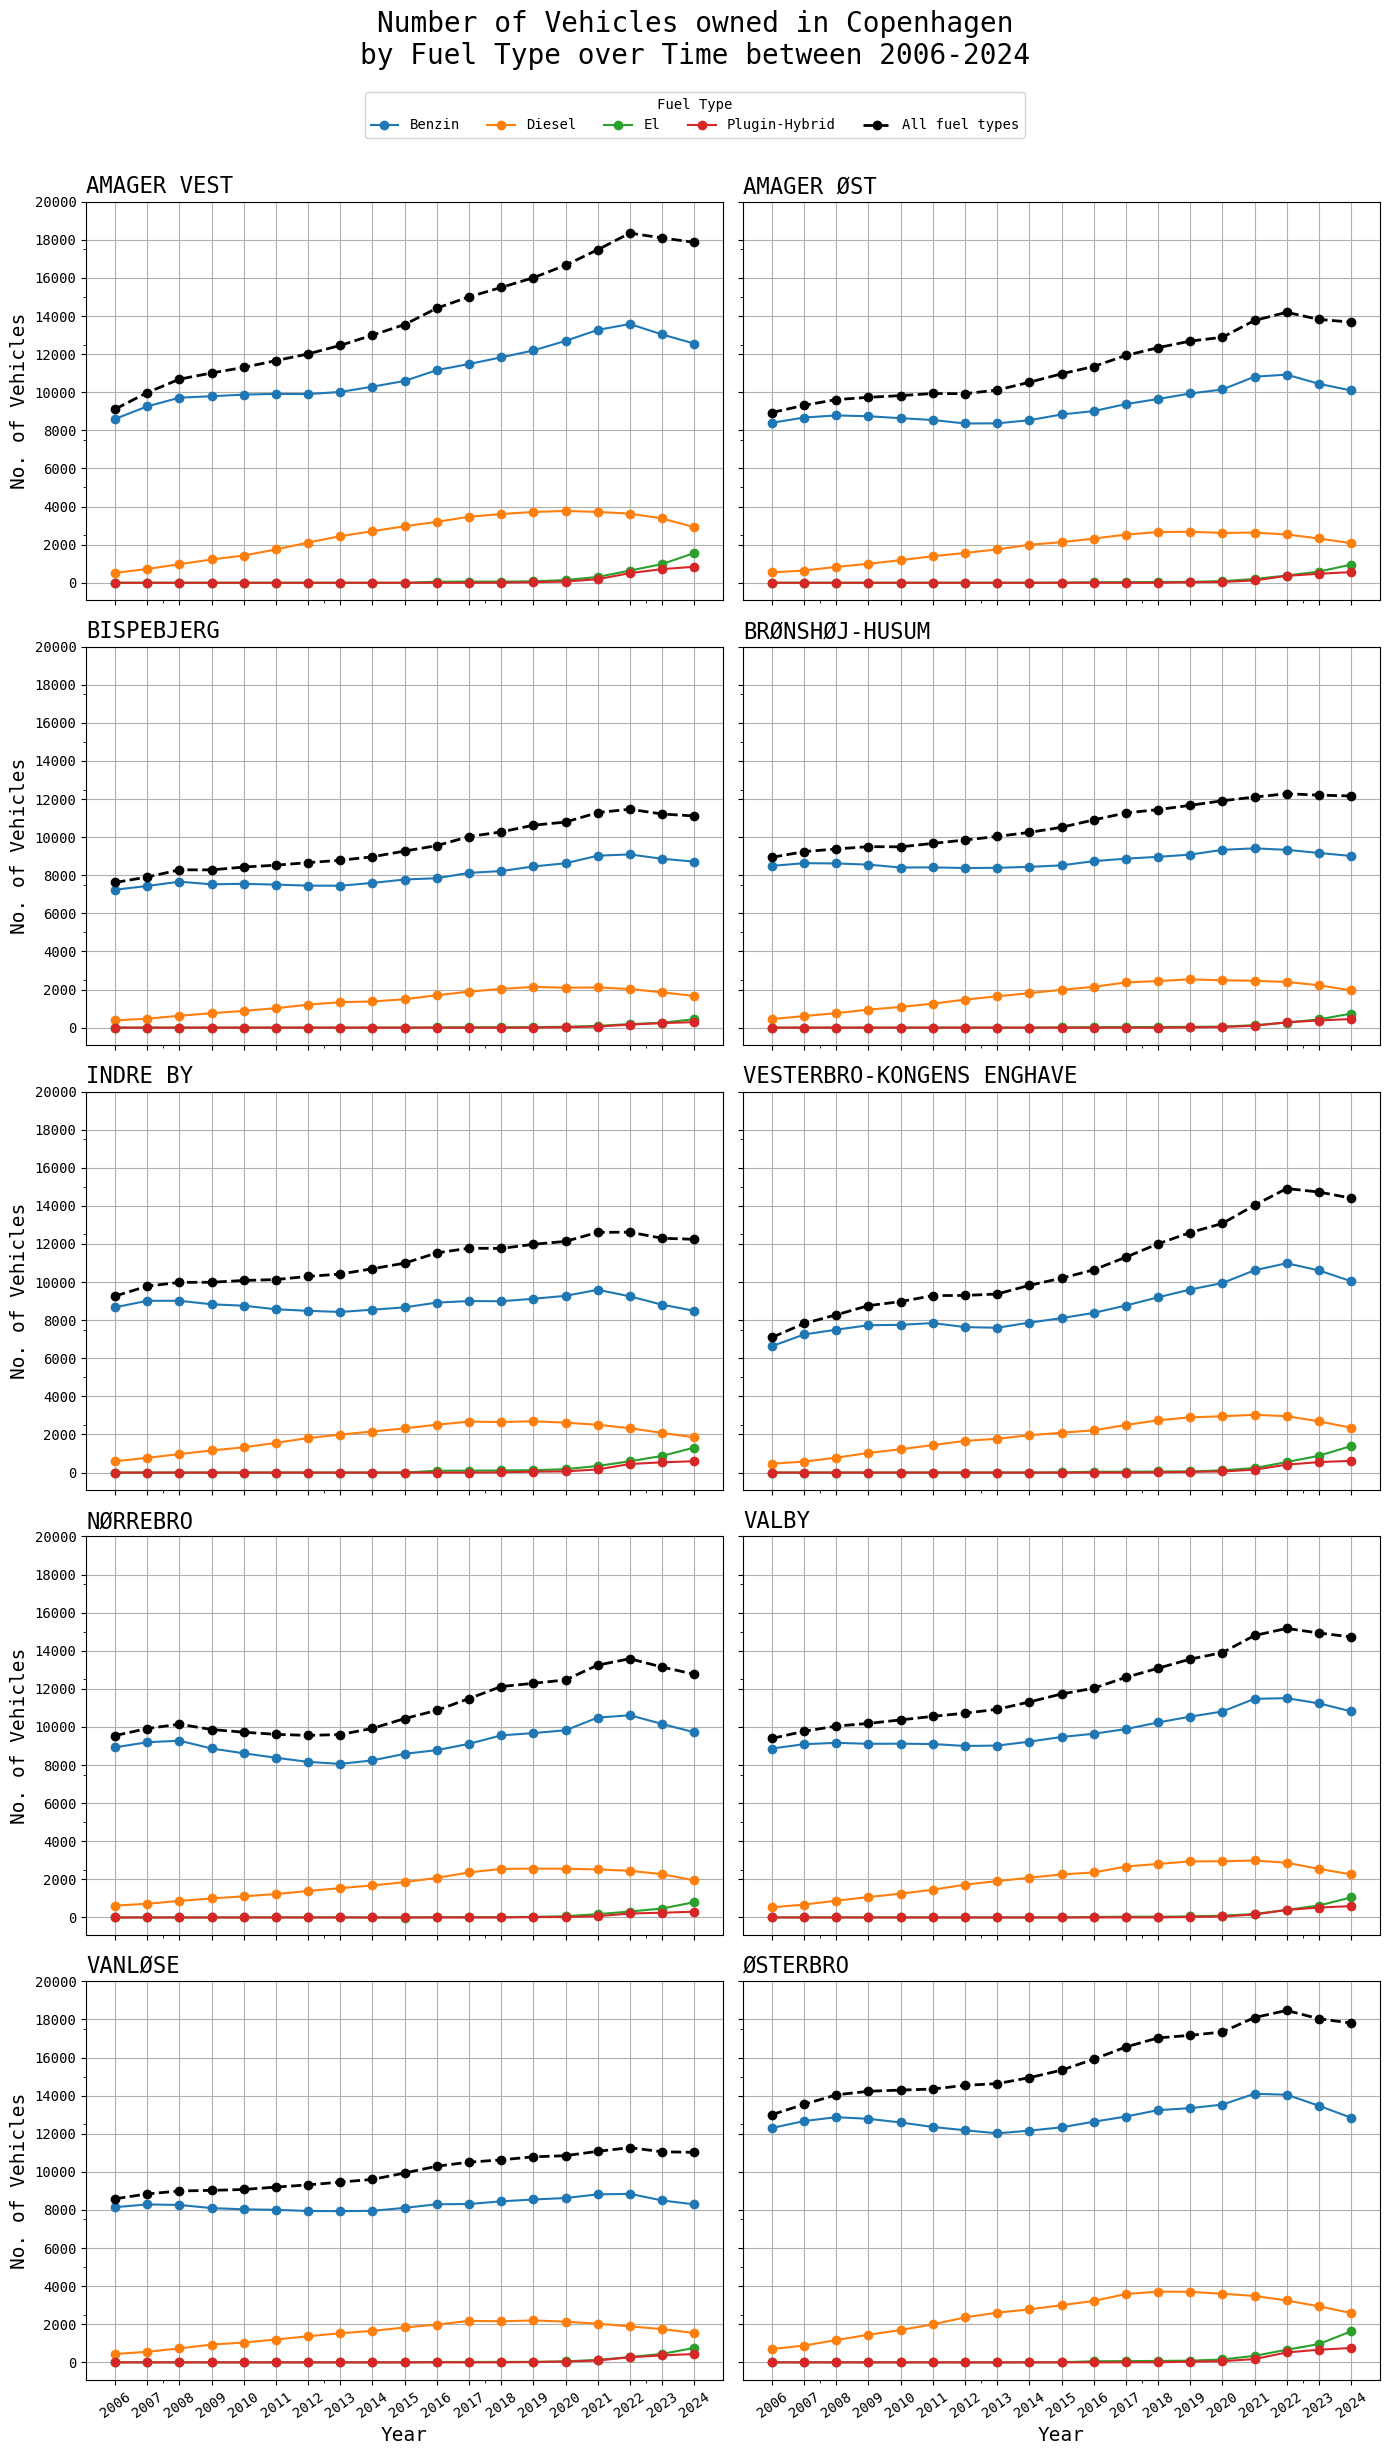

In [87]:
# Get unique CityDistricts
districts = df_clean["CityDistrict"].dropna().unique()

# Compute dimensions for subplots
n = len(districts)
ncols = 2
nrows = math.ceil(n / ncols)

# Create the subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, nrows * 5), sharex=True, sharey=True)

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through districts and create each subplot
for i, district in enumerate(districts):
    ax = axes[i]

    # Group by year and fuel type, then summarize by noofvehicles, then fiannly pivot to correst format
    df_district = df_clean[df_clean["CityDistrict"] == district]
    df_grouped = df_district.groupby(["Year", "FuelType"])["NoOfVehicles"].sum().reset_index()
    df_pivot = df_grouped.pivot(index="Year", columns="FuelType", values="NoOfVehicles")

    if df_pivot.empty:
        ax.set_visible(False)
        continue

    # Plot data
    df_pivot.plot(ax=ax, marker='o', legend=False)  # legend off here, we'll do one globally

    # Compute the total no. of vehicles per year for all fuel types combined
    df_total = df_pivot.sum(axis=1).reset_index()
    df_total.columns = ["Year", "TotalVehicles"]
    ax.plot(df_total["Year"], df_total["TotalVehicles"], color='black', marker='o', label='All fuel types', linestyle='--', linewidth=2)
        
    # x-axis
    ax.set_xticks(df_pivot.index)
    ax.set_xticklabels(df_pivot.index, rotation=35)

    # y-axis ticks
    interval = 2_000
    max_val = 20_000
    top_val = int(math.ceil(max_val / interval)) * interval
    yticks = list(range(0, top_val + interval, interval))
    ax.set_yticks(yticks)

    # Titles, labels and grid
    ax.set_title(district.upper(), loc="left", fontdict={'family':font_defined,'color':'black','size':16})
    ax.set_xlabel("Year", fontdict={'family':font_defined,'color':'black','size':14})
    ax.set_ylabel("No. of Vehicles", fontdict={'family':font_defined,'color':'black','size':14})
    ax.grid(visible=True)

# Set a global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Fuel Type", loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=len(labels))

plt.rcParams['font.family'] = font_defined
plt.suptitle(t=f"Number of Vehicles owned in Copenhagen\nby Fuel Type over Time between {start_y}-{end_y}", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
plt.show()


# Geographic representation of Copenhagen

## Quick overview of geojson

In [88]:
print("Dataset: GeoJSON of CPH")
file_size = os.path.getsize(geojson_path)/1024
print(f"- File Size: {file_size:.2f} KB")

print("\nGeoJSON feature properties:")
for p in geojson_data["features"][0]["properties"]:
    print(f"- {p}")

Dataset: GeoJSON of CPH
- File Size: 244.71 KB

GeoJSON feature properties:
- id
- bydel_nr
- navn
- areal_m2
- ogc_fid


In [89]:
df_geojson = pd.DataFrame(columns=["Id", "BydelNr", "Name", "Area"])
df_geojson = df_geojson.astype({"Id": "uint8", "Name": str, "Area": float}) # just for removing warning

for f in geojson_data["features"]:
    new_row = pd.DataFrame(data=[[
        f["properties"]["id"],
        f["properties"]["bydel_nr"], 
        f["properties"]["navn"], 
        f["properties"]["areal_m2"]
    ]], columns=[
        "Id", 
        "BydelNr", 
        "Name", 
        "Area"
    ])
    df_geojson = pd.concat([df_geojson, new_row], axis=0, ignore_index=True)

df_geojson = df_geojson.sort_values(
    by=["Name"], 
    axis=0,
    ascending=True)

df_geojson

,Id,BydelNr,Name,Area
0,33,10,Amager Vest,19364649.0
9,9,9,Amager Øst,9345320.0
8,8,8,Bispebjerg,6829937.0
4,7,7,Brønshøj-Husum,8740777.0
6,1,1,Indre By,10471832.0
7,3,3,Nørrebro,4107777.0
3,35,5,Valby,9235113.0
5,6,6,Vanløse,6699013.0
1,34,4,Vesterbro-Kongens Enghave,8262147.0
2,36,2,Østerbro,9772935.0


## Find the center point of the GeoJSON locations

### Helper functions

In [90]:
# Find the minimum and maximum longitude and latitude values
def get_min_max_from_feature(data):
    lon_min, lon_max = (min(x[0] for x in data), max(x[0] for x in data))
    lat_min, lat_max = (min(x[1] for x in data), max(x[1] for x in data))
    return lon_min, lon_max, lat_min, lat_max


# Get the minimum and maximum longitude and latitude values from geojson
def get_min_max_lon_lat(geojson):
    lons = []
    lats = []
    for feat in geojson["features"]:
        if feat["geometry"]["type"] == "Polygon":
            f = feat["geometry"]["coordinates"][0]
            lon_min, lon_max, lat_min, lat_max = get_min_max_from_feature(f)
            lons.append(lon_min)
            lons.append(lon_max)
            lats.append(lat_min)
            lats.append(lat_max)
        elif feat["geometry"]["type"] == "MultiPolygon":
            for poly in feat["geometry"]["coordinates"]:
                f = poly[0]
                lon_min, lon_max, lat_min, lat_max = get_min_max_from_feature(f)
                lons.append(lon_min)
                lons.append(lon_max)
                lats.append(lat_min)
                lats.append(lat_max)
    return min(lons), max(lons), min(lats), max(lats)


# Find center of the map
def get_center_lon_lat(geojson):
    lon_min, lon_max, lat_min, lat_max = get_min_max_lon_lat(geojson)
    return [(lon_max + lon_min) / 2, (lat_max + lat_min) / 2]

### Calculate center of Copenhagen data

In [91]:
# Get the center of the map
cph_coords = get_center_lon_lat(geojson_data)
cph_coords

[12.593649305, 55.67277732]

## Create map with districts highlighted

In [92]:
# Create a map around CPH's center point
folium_heatmap_timeseries = folium.Map(location=[cph_coords[1], cph_coords[0]], zoom_start=12, tiles="cartodbpositron")

# Parse geojson data into the heatmap
folium.GeoJson(
    geojson_data,
    name = "Districts",
    highlight_function=lambda feature: {
        "fillColor": "#FFCC00",
        "fillOpacity": 0.3,
        "weight": 2.0,
        "dashArray": "1, 1",
    },
    style_function = lambda feature: {
        "fillColor": "red",
        "color": "black",
        "weight": 1.0,
        "fillOpacity": 0.3,
        "dashArray": "3, 3",
    },
).add_to(folium_heatmap_timeseries)

In [93]:
folium_heatmap_timeseries